In [1]:
import torch.nn    as nn
import torch.optim as optim
import GM_library  as GML
import numpy       as np
import torch

from os                   import path, listdir
from torch.utils.data     import random_split
from torch_geometric.data import Data

import sys
sys.path.append('../')
import MP.MP_library as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Machine-learning parameters
n_epochs      = 1000
batch_size    = 128
learning_rate = 0.0001

# Number of diffusing and denoising steps, which can be different
n_diffusing_steps = 20
n_denoising_steps = 20

# Decay of parameter alpha
alpha_decay = 1e-6

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

In [3]:
graph = GML.get_random_graph(5, 1)

graph.x         = torch.abs(graph.x) * 100
graph.edge_attr = torch.abs(graph.edge_attr)

In [7]:
import importlib
importlib.reload(GML)

<module 'GM_library' from '/Users/cibran/Work/UPC/GenerativeModels/GM_library.py'>

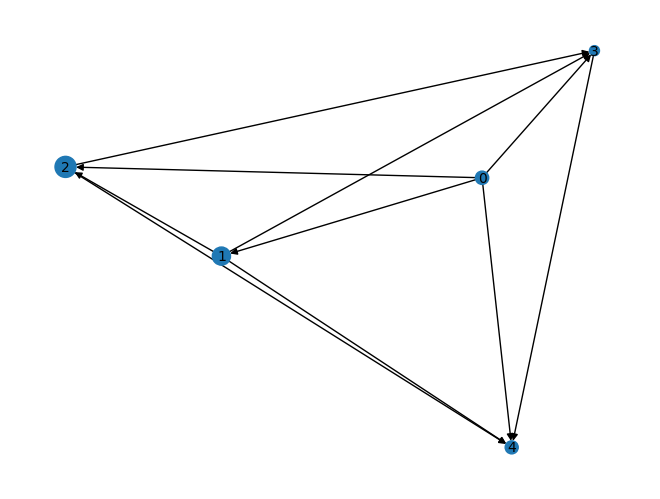

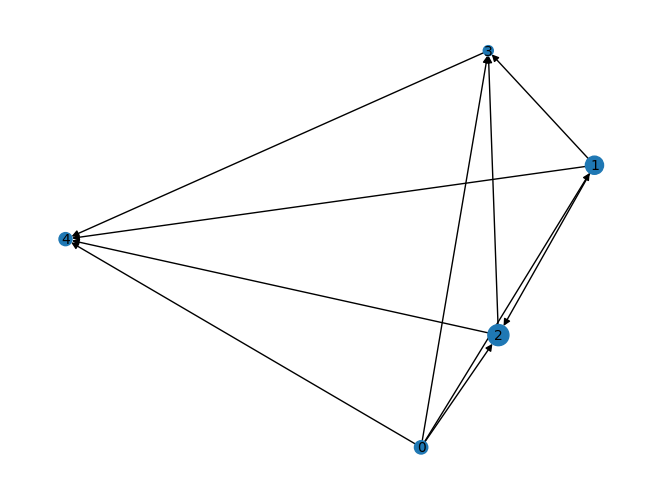

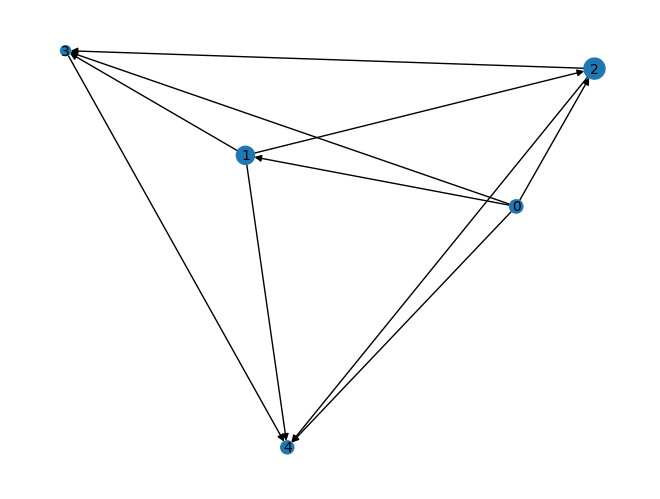

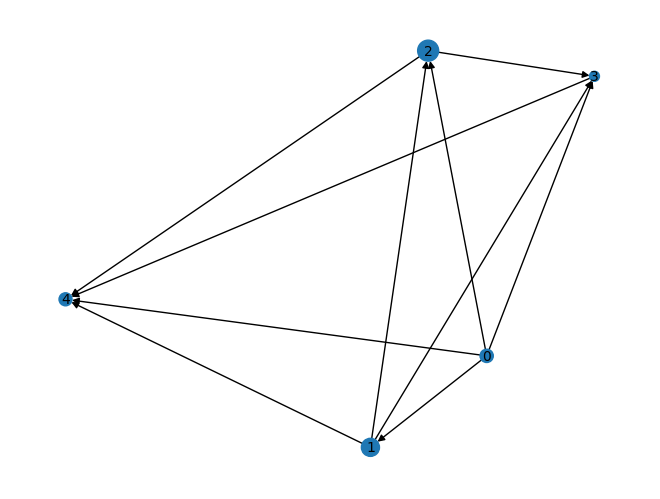

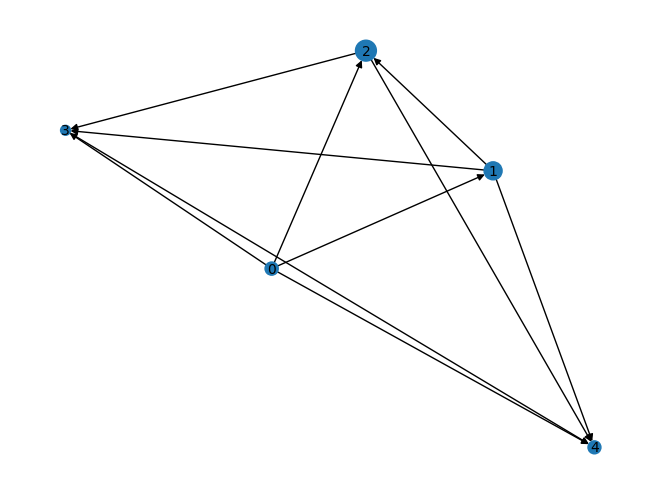

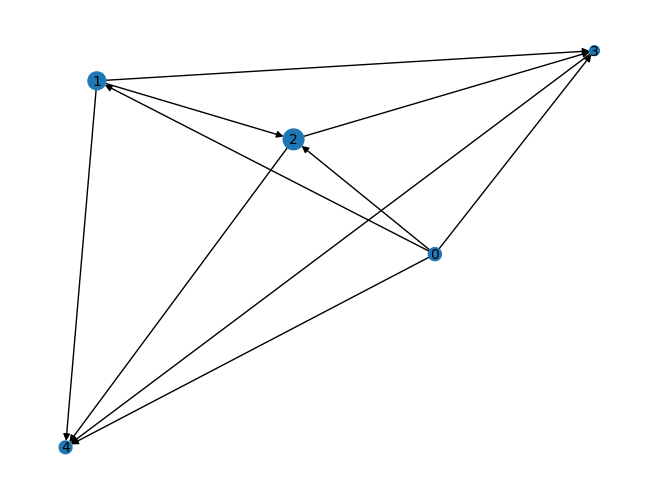

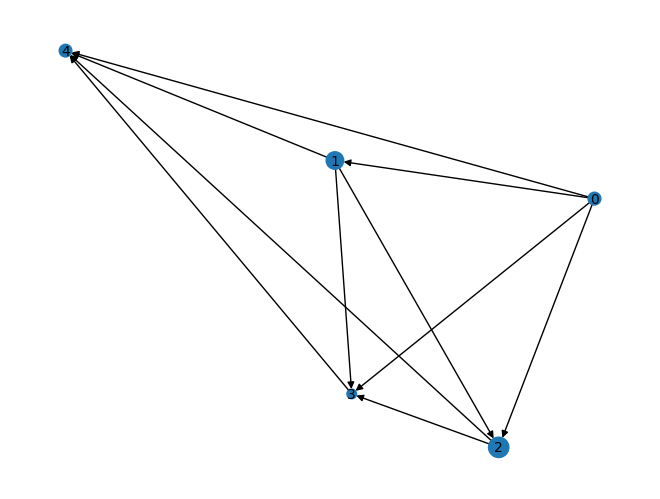

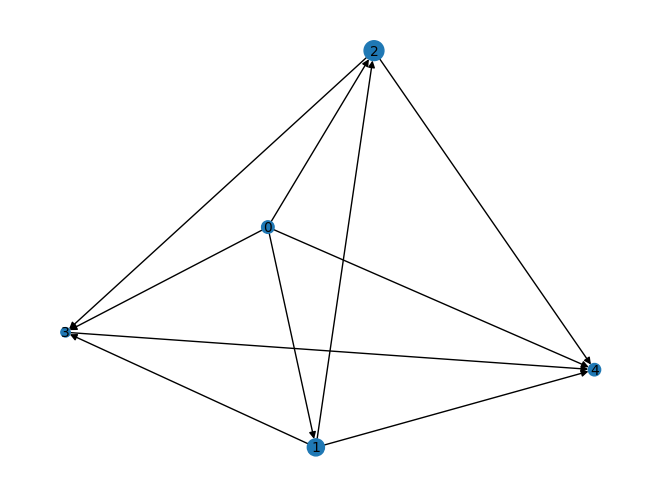

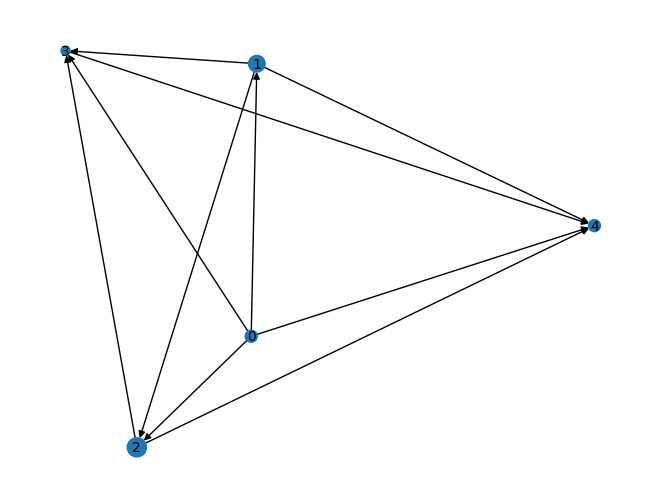

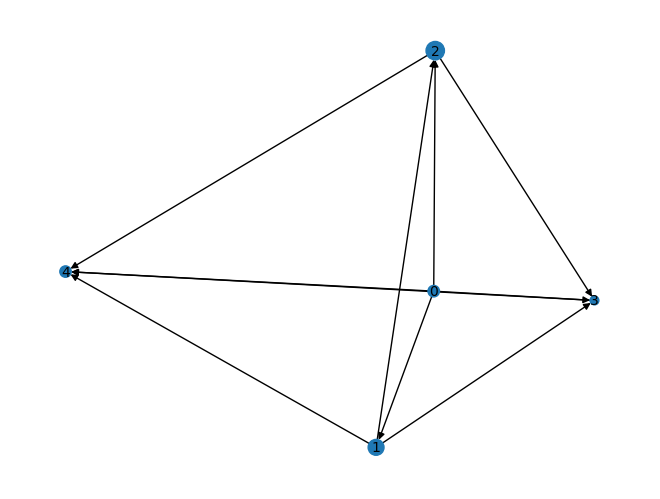

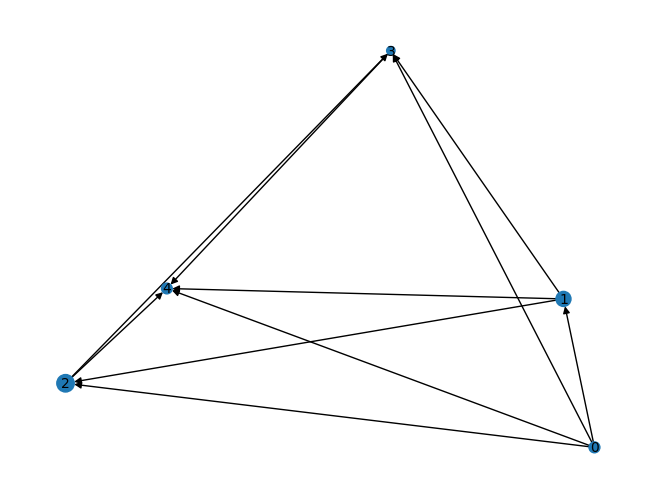

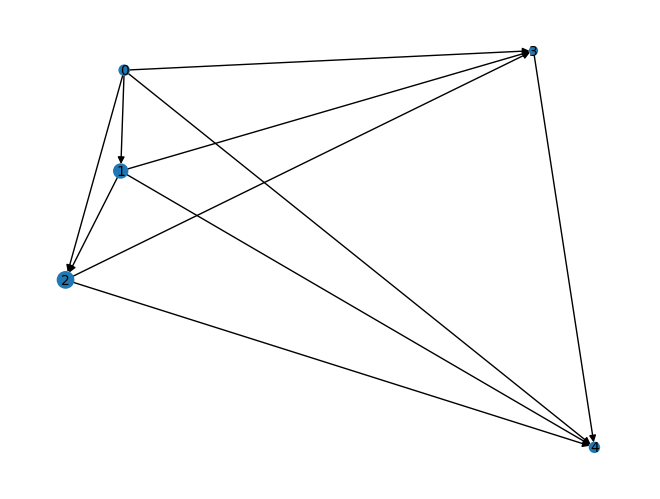

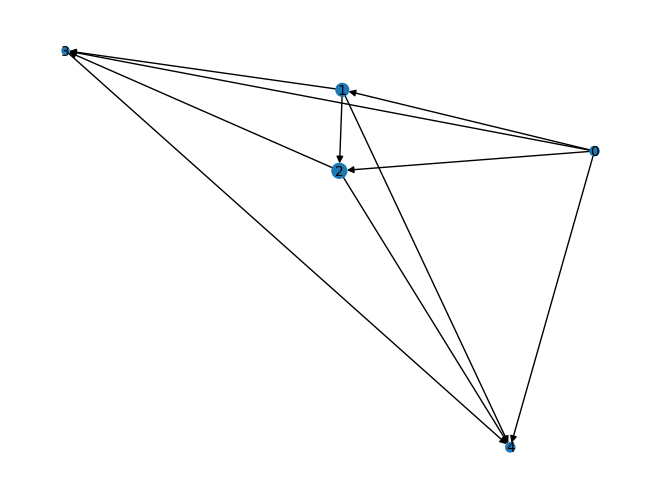

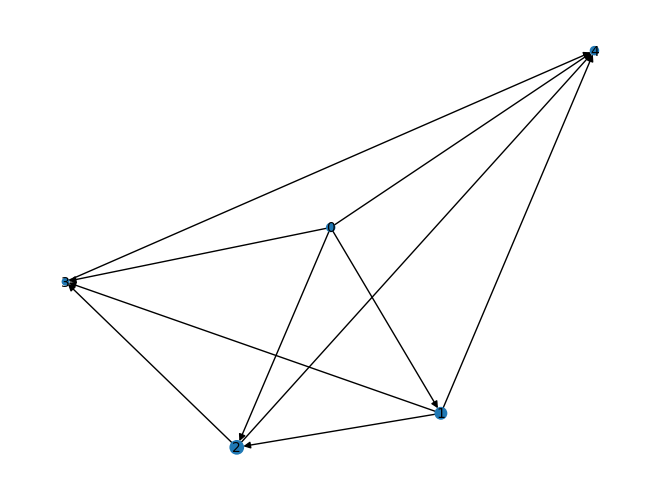

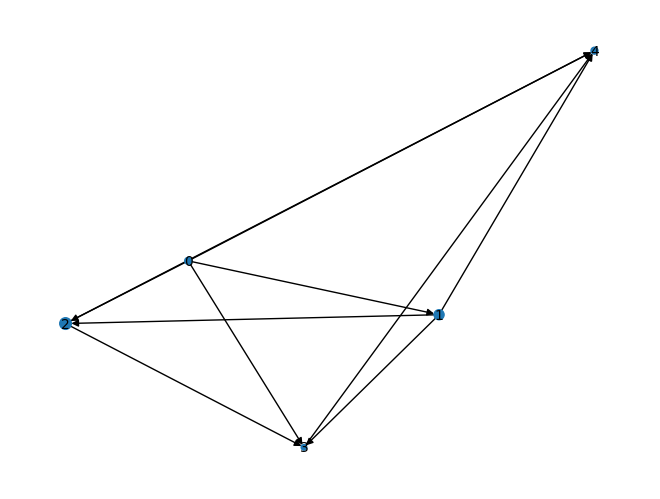

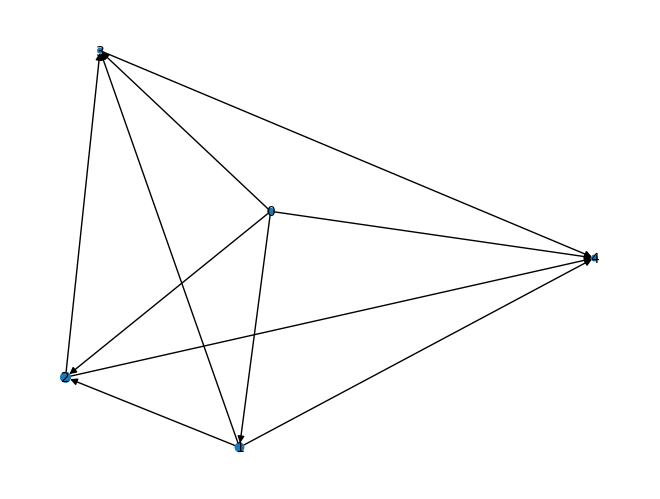

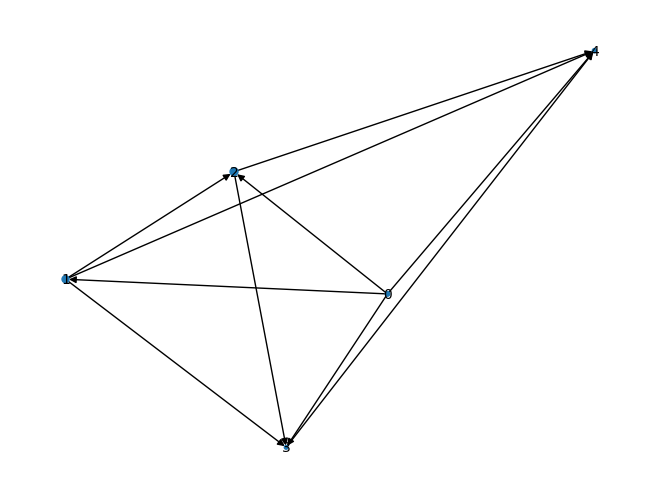

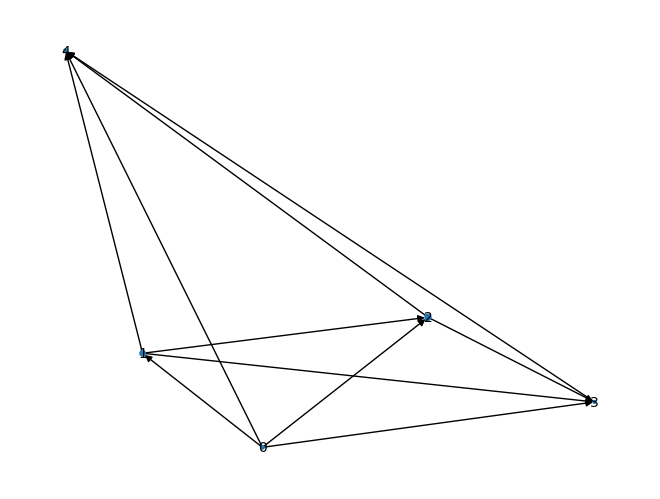

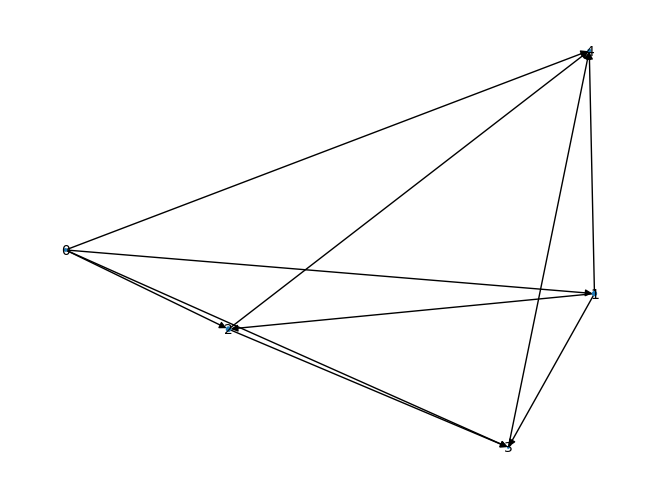

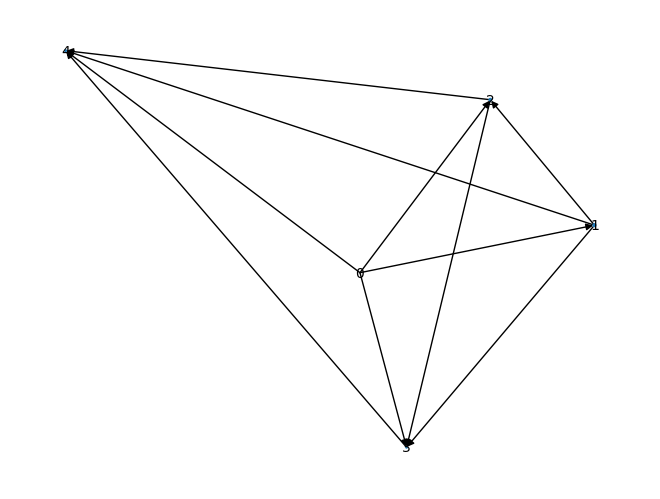

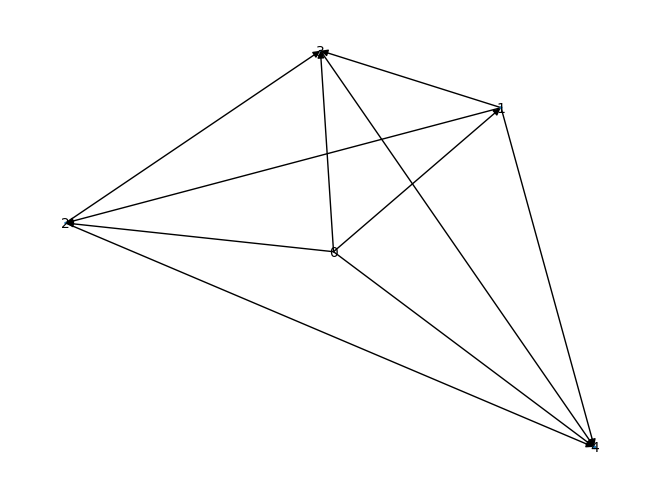

In [10]:
diffused_graph = GML.diffuse(graph, n_diffusing_steps,
                             s=alpha_decay, plot_steps=True)

In [ ]:
node_model = torch.load()
edge_model = torch.load()

In [ ]:
denoised_graph = GML.denoise(diffused_graph, n_denoising_steps, node_model, edge_model,
                             s=alpha_decay, plot_steps=True)